In [1]:
import os
import json
import time
import torch
import matplotlib.pyplot as plt

from torch.nn import L1Loss
from monai.utils import set_determinism, first
from monai.networks.nets import ViTAutoEnc
from monai.losses import ContrastiveLoss
from monai.data import DataLoader, Dataset
from monai.config import print_config
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    EnsureChannelFirstd,
    Spacingd,
    OneOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    ScaleIntensityd
)

print_config()


MONAI version: 1.4.dev2414
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5b248f6a0dd29cb9c2a9545f980a88de16a6b753
MONAI __file__: /home/<username>/virtenvs/SSLUnet/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.3
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about insta

In [2]:
# Load NRRD file
import nrrd
nrrd_file_path = "./Data/FrenchSpeakerDataset/NRRD_Files_N4Bias/P1_2.nrrd"
data, header = nrrd.read(nrrd_file_path)

In [5]:
# Define Training Transforms
train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #Defines the image intensity
        ScaleIntensityd(keys=["image"], minv=-0.0, maxv=1.0),
        CropForegroundd(keys=["image"], source_key="image"),
        SpatialPadd(keys=["image"], spatial_size=(64, 64, 64)),
        RandSpatialCropSamplesd(keys=["image"], roi_size=(
            64, 64, 64), random_size=False, num_samples=2),
        CopyItemsd(keys=["image"], times=2, names=[
            "gt_image", "image_2"], allow_missing_keys=False),
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=32
                ),
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image"], prob=0.8, holes=10, spatial_size=8),
        # Please note that that if image, image_2 are called via the same transform call because of the determinism
        # they will get augmented the exact same way which is not the required case here, hence two calls are made
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=32
                ),
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image_2"], prob=0.8,
                           holes=10, spatial_size=8),
    ]
)

# Load NRRD file
nrrd_file_path = "Data/FrenchSpeakerDataset/NRRD_Files_N4Bias/P10_y.nrrd"
data, header = nrrd.read(nrrd_file_path)

# Create a dictionary with your image data
data_dict = {"image": nrrd_file_path}

# Apply the transformations
transformed_data_dict = train_transforms(data_dict)

# Visualize the original and transformed images
original_image = data_dict["image"]  # assuming the original image is 3D


In [6]:
transformed_data_dict[0]["gt_image"].shape
#plt.imshow(transformed_image["image"]["gt_image"][:,:,15])

torch.Size([1, 64, 64, 64])

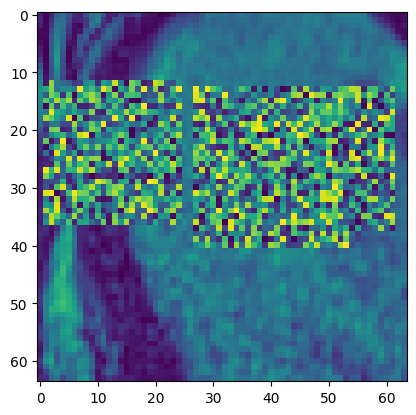

In [55]:
# Plot original and transformed images
import matplotlib.pyplot as plt
plt.imshow(transformed_image[0]["image_2"].numpy()[0, :, :, 40])


In [56]:
# Access the original and duplicated images
original_image = transformed_data_dict[0]["image"]
gt_image = transformed_data_dict[0]["gt_image"]
image_2 = transformed_data_dict[0]["image_2"]

# Print the keys and shapes of the images
print("Original Image Shape:", original_image.shape)
print("GT Image Shape:", gt_image.shape)
print("Image 2 Shape:", image_2.shape)


Original Image Shape: torch.Size([1, 64, 64, 64])
GT Image Shape: torch.Size([1, 64, 64, 64])
Image 2 Shape: torch.Size([1, 64, 64, 64])
